# P8 Déployez un modèle dans le cloud

1. Importation des librairies
2. Découverte du dataset
3. Preprocessing
4. Réduction de dimension

## I. Importation des librairies et chargement des données

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

/home/clalbertini7/anaconda3/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.0.0' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
import findspark
findspark.init()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from tensorflow import keras

In [6]:
# Pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType
from pyspark.sql.functions import split, col, udf
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler, StringIndexer, MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler

from PIL import Image
import io
from urllib.parse import unquote
#Tensorflow 
#import ResNet50
#from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

Chargement des données

In [7]:
# https://cloud.google.com/storage/docs/reference/libraries

from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "fruits-data"

# une variable qui référence le bucket fruites-data afin de pouvoir interagir avec 
bucket = storage_client.get_bucket(bucket_name)

In [8]:
# Get blobs in bucket (including all subdirectories)
blobs_test = list(bucket.list_blobs(prefix='fruits-360_dataset/fruits-360/Test'))

## II. Découverte du dataset

1. bytes vers objet RDD (librairie UDF)construire une fonction qui permet d'ouvrir l'image et de retourner l'image: utiliser la librairie PIL from PIL import Image, Image.open(io.BytesIO()), resize image 224*224(conseillé pour les réseaux de neuronnes)

len(blobs_test)

In [9]:
blob_limited = blobs_test[:10]

In [10]:
blobs_test[0]

<Blob: fruits-data, fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg, 1643326881690396>

In [11]:
blobs_test[1].content_type

'image/jpeg'

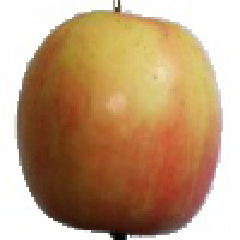

In [12]:
Image.open(io.BytesIO(blobs_test[1000].download_as_bytes())).resize([240, 240])

In [13]:
#for blob in blob_limited:
#    file_name = blob.name.replace("fruits-360_dataset/fruits-360/Test/Apple Braeburn/", "")
#    blob.download_to_filename(file_name)

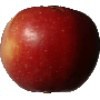

In [14]:
Image.open(io.BytesIO(blobs_test[10].download_as_bytes()))

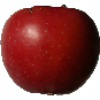

In [15]:
Image.open(io.BytesIO(blobs_test[50].download_as_bytes()))

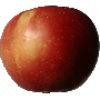

In [16]:
Image.open(io.BytesIO(blobs_test[70].download_as_bytes()))

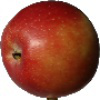

In [17]:
Image.open(io.BytesIO(blobs_test[90].download_as_bytes()))

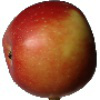

In [18]:
Image.open(io.BytesIO(blobs_test[110].download_as_bytes()))

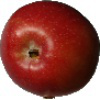

In [19]:
Image.open(io.BytesIO(blobs_test[130].download_as_bytes()))

Voir nombre de fruits/catégories différentes

## III. Preprocessing

2. Importer modèle ResNet50, modele summury pour le nombre de couches (expliquer dans pres)/ présentation: expliquer qq elets du resnet50
3. Enlever la derniere couches, récup sortie avant dernière couche pour extraire les features.

Importation du modèle à partir de keras mais sans couche supérieure (classificateur), car nous voulons uniquement que ce modèle extraie les features.

Resizer toutes les images à 224*224

In [20]:
# à mettre en UDF
def resize_and_features(blob):
    img = Image.open(io.BytesIO(blob.download_as_bytes())).resize([224, 224])
    nom_fruit = unquote(blob.public_url.split("/")[-2])
    # à ajouter resnet
    return img, nom_fruit

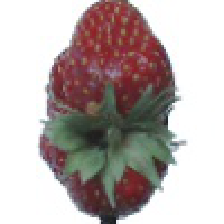

In [21]:
img_tst = resize_and_features(blobs_test[20000])[0]
img_tst

In [22]:
blobs_test[20000].public_url

'https://storage.googleapis.com/fruits-data/fruits-360_dataset/fruits-360/Test/Strawberry%20Wedge/r_102_100.jpg'

In [23]:
resize_and_features(blobs_test[20000])[1]

'Strawberry Wedge'

In [24]:
# transformer l'image en array (tableau)
arr_test = img_to_array(img_tst)
arr_test

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [25]:
# redimensionne l'array et preprocessing avec Resnet50
preproc_test = preprocess_input(np.expand_dims(arr_test, axis=0))
preproc_test

array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


In [26]:
preproc_test.shape

(1, 224, 224, 3)

Prédiction avec ResNet50

In [27]:
model = ResNet50()
prediction = model.predict(preproc_test)

In [28]:
prediction.shape

(1, 1000)

In [29]:
from tensorflow.keras.applications.resnet50 import decode_predictions
predictionLabel = decode_predictions(prediction, top = 1)
predictionLabel

[[('n07745940', 'strawberry', 0.99907863)]]

In [30]:
img_to_array

<function tensorflow.python.keras.preprocessing.image.img_to_array>

In [31]:
model_without_top_layer = ResNet50(include_top=False)

In [32]:
img_test = Image.open(io.BytesIO(blobs_test[20000].download_as_bytes())).resize([224, 224])
arr_test = img_to_array(img_tst)
processed_input = preprocess_input(np.expand_dims(arr_test, axis=0))
predictions = model_without_top_layer.predict(processed_input)

In [33]:
len(predictions.flatten())

100352

In [34]:
predictions.shape

(1, 7, 7, 2048)

## Importer les données dans une dataframe Spark

In [35]:
os.environ["PYSPARK_PYTHON"] = "/home/clalbertini7/anaconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/clalbertini7/anaconda3/bin/python3"

In [36]:
os.environ

environ({'LANG': 'C.UTF-8', 'XDG_SESSION_CLASS': 'user', 'PYSPARK_PYTHON': '/home/clalbertini7/anaconda3/bin/python3', 'XDG_SESSION_ID': '1', 'GOOGLE_APPLICATION_CREDENTIALS': '/home/clalbertini7/eloquent-hangar.json', 'HADOOP_CLASSPATH': ':/home/clalbertini7/gcs-connector-hadoop3-latest.jar', 'USER': 'clalbertini7', '_': '/home/clalbertini7/anaconda3/bin/jupyter', 'PATH': '/home/clalbertini7/anaconda3/bin:/home/clalbertini7/anaconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games/usr/lib/jvm/java-11-openjdk-amd64/bin:/opt/spark/bin:/opt/spark/sbin', 'PWD': '/home/clalbertini7', 'SSH_TTY': '/dev/pts/0', 'SHLVL': '1', 'SSH_CONNECTION': '35.235.243.225 40489 10.132.0.4 22', 'PAGER': 'cat', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz

In [37]:
spark = (SparkSession
         .builder.master('local[*]')
         .appName('Projet8')
         .config("spark.jars","/home/clalbertini7/gcs-connector-hadoop3-latest.jar")
         .config("spark.driver.extraJavaOptions","-Dio.netty.tryReflectionSetAccessible=true")
         .config("spark.executor.extraJavaOptions","-Dio.netty.tryReflectionSetAccessible=true")
         .getOrCreate())

/home/clalbertini7/anaconda3/lib/python3.5/site-packages/pyspark/context.py:227: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [38]:
sc = spark.sparkContext
spark._jsc.hadoopConfiguration().set('fs.AbstractFileSystem.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS')
spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
# This is required if you are using service account and set true, 
spark._jsc.hadoopConfiguration().set('fs.gs.auth.service.account.enable', 'true')
spark._jsc.hadoopConfiguration().set('google.cloud.auth.service.account.json.keyfile', "/home/clalbertini7/eloquent-hangar.json")

In [39]:
gs_url = "gs://fruits-data/fruits-360-PCA/*"
image_df = spark.read.format("binaryfile").load(gs_url)
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [40]:
image_df.select('path', 'content').show()

+--------------------+--------------------+
|                path|             content|
+--------------------+--------------------+
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
|gs://fruits-data/...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+



In [41]:
images_with_label = image_df.withColumn('label', split(col('path'), '/').getItem(4))
images_with_label.show()

+--------------------+--------------------+------+--------------------+------------------+
|                path|    modificationTime|length|             content|             label|
+--------------------+--------------------+------+--------------------+------------------+
|gs://fruits-data/...|2022-02-08 21:32:...|  5083|[FF D8 FF E0 00 1...|              Kiwi|
|gs://fruits-data/...|2022-02-08 21:32:...|  4965|[FF D8 FF E0 00 1...|              Kiwi|
|gs://fruits-data/...|2022-02-08 21:32:...|  4473|[FF D8 FF E0 00 1...|           Apricot|
|gs://fruits-data/...|2022-02-08 21:32:...|  4404|[FF D8 FF E0 00 1...|           Apricot|
|gs://fruits-data/...|2022-02-08 21:32:...|  4162|[FF D8 FF E0 00 1...|Apple Granny Smith|
|gs://fruits-data/...|2022-02-08 21:32:...|  4059|[FF D8 FF E0 00 1...|Apple Granny Smith|
|gs://fruits-data/...|2022-02-08 21:32:...|  3937|[FF D8 FF E0 00 1...|          Chestnut|
|gs://fruits-data/...|2022-02-08 21:32:...|  3415|[FF D8 FF E0 00 1...|          Chestnut|

In [42]:
images_with_label.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



In [43]:
images_with_label.dtypes

[('path', 'string'),
 ('modificationTime', 'timestamp'),
 ('length', 'bigint'),
 ('content', 'binary'),
 ('label', 'string')]

In [44]:
broadcast_model_weights = spark.sparkContext.broadcast(model_without_top_layer.get_weights()) 

In [45]:
# @udf('array<float>')
def extract_features(content, model_interne):
    img_content = Image.open(io.BytesIO(content)).resize([224, 224])
    arr_content = img_to_array(img_content)
    processed_content = preprocess_input(np.expand_dims(arr_content, axis=0))
    predictions = model_interne.predict(processed_content)
    return predictions.flatten()

In [46]:
def extract_features_series(model_interne, content_b_series):
    output = np.stack(content_b_series.apply(extract_features, args=(model_interne,))) 
    output = [p.flatten() for p in output]
    return pd.Series(output)

In [47]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model_interne = ResNet50(weights=None, include_top=False) 
    model_interne.set_weights(broadcast_model_weights.value)
    for content_series in content_series_iter:
        yield extract_features_series(model_interne, content_series)

In [48]:
images_with_features = images_with_label.select(col("path"), col("label"), featurize_udf("content").alias("features"))

In [49]:
images_with_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [50]:
images_with_features.show()

+--------------------+------------------+--------------------+
|                path|             label|            features|
+--------------------+------------------+--------------------+
|gs://fruits-data/...|              Kiwi|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|              Kiwi|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|           Apricot|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|           Apricot|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|Apple Granny Smith|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|Apple Granny Smith|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|          Chestnut|[0.0, 0.0, 0.0, 0...|
|gs://fruits-data/...|          Chestnut|[0.0, 0.0, 0.0, 0...|
+--------------------+------------------+--------------------+



In [51]:
vectorize_feats = udf(lambda l: Vectors.dense(l), VectorUDT())
images_with_features_vector = images_with_features.select(col("path"),  col("label"), vectorize_feats(images_with_features["features"]).alias("features"))

In [52]:
images_with_features_vector.show()

+--------------------+------------------+--------------------+
|                path|             label|            features|
+--------------------+------------------+--------------------+
|gs://fruits-data/...|              Kiwi|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|              Kiwi|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|           Apricot|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|           Apricot|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|Apple Granny Smith|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|Apple Granny Smith|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|          Chestnut|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|          Chestnut|[0.0,0.0,0.0,0.0,...|
+--------------------+------------------+--------------------+



In [53]:
# https://stackoverflow.com/questions/55595263/how-to-fix-no-filesystem-for-scheme-gs-in-pyspark
# https://stackoverflow.com/questions/62109276/errorjava-lang-unsupportedoperationexception-for-pyspark-pandas-udf-documenta
# https://github.com/GoogleCloudDataproc/hadoop-connectors/blob/master/gcs/INSTALL.md

## IV. Réduction de dimension

4. appliquer sandart scaler Puis faire PCA
le transformer par une fonction / ou créer un pyspark dataframe pour récup les features.
5. tracer la cumulative explained variance
6. affiches image originale et l'image reconstruire à partir de la PCA

In [54]:
images_with_features_vector.dtypes

[('path', 'string'), ('label', 'string'), ('features', 'vector')]

In [55]:
scaler = StandardScaler(inputCol='features',
                              outputCol='feats_scaled')
std = scaler.fit(images_with_features_vector)

In [56]:
images_with_features_std = std.transform(images_with_features_vector)
images_with_features_std.show()

+--------------------+------------------+--------------------+--------------------+
|                path|             label|            features|        feats_scaled|
+--------------------+------------------+--------------------+--------------------+
|gs://fruits-data/...|              Kiwi|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|              Kiwi|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|           Apricot|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|           Apricot|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|Apple Granny Smith|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|Apple Granny Smith|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|          Chestnut|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://fruits-data/...|          Chestnut|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
+--------------------+------------------+--------------------+--------------

In [57]:
pca = PCA(k=7, inputCol="feats_scaled", outputCol="pca")
modelpca = pca.fit(images_with_features_std)
transformed = modelpca.transform(images_with_features_std)

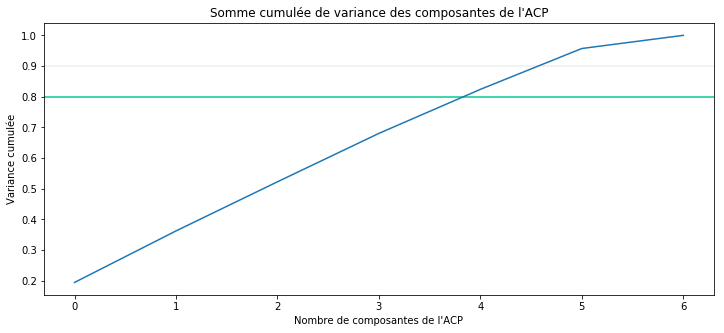

In [58]:
var = modelpca.explainedVariance.cumsum()
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.axhline(y=0.8, color='#02CA91', linestyle='-')
plt.axhline(y=0.9, color='#efefef', linestyle='-')
plt.plot(range(7),
         modelpca.explainedVariance.cumsum())
plt.show()

In [59]:
! pip install gcsfs

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [61]:
transformed_pca = transformed.select('path', 'label', 'pca')
transformed_pandas = transformed_pca.toPandas()
transformed_pandas.to_csv("pca.csv")